# Tabular data workflow

## Point-based

In [ ]:
import rasterio as rio
import geopandas as gpd
from pathlib import Path
import rasterio.plot as rioplot
import matplotlib.pyplot as plt

In [ ]:
path_to_data = Path('workflow_examples/')
raster_data = path_to_data/'s2_2018_lataseno.tif'
point_data = path_to_data/'points_clc.geojson'

Example data here are Sentinel 2 mosaic from 2018, with 9 bands, and scattered point observations from that area. Target class for the points is Corine Land Cover class for the corresponding location

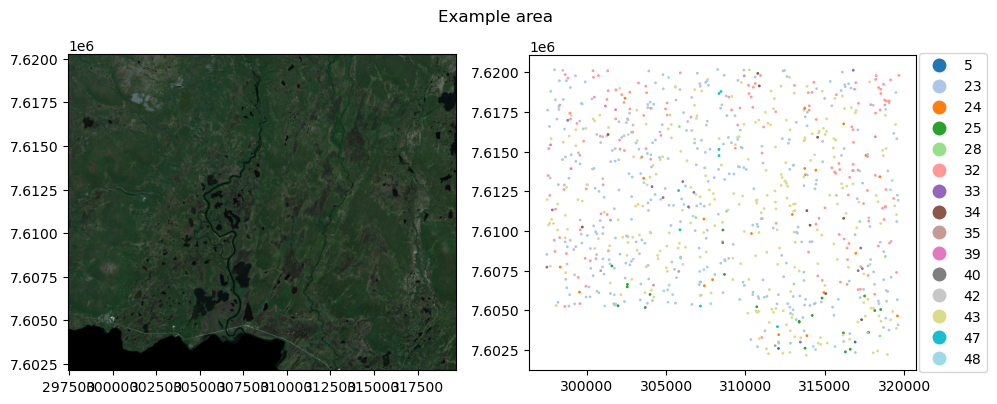

In [ ]:
fig, axs = plt.subplots(1,2, dpi=100, figsize=(10,4))
with rio.open(raster_data) as src:
    rioplot.show((src, (3,2,1)), adjust=True, ax=axs[0])
train_gdf = gpd.read_file(point_data)
train_gdf['corine'] = train_gdf.corine.astype('category')
train_gdf.plot(column='corine', ax=axs[1], cmap='tab20', markersize=1, legend=True,
               legend_kwds={'loc':'right', 'bbox_to_anchor':(1.2,0.5)})
plt.suptitle('Example area')
plt.tight_layout()
plt.show()

### Create the dataset

#### CLI

```bash
geo2ml_sample_points \
example_data/workflow_examples/points_clc.geojson \
example_data/workflow_examples/s2_2018_lataseno.tif \
corine \
example_data/workflow_examples/points/ \
--out_prefix example
```

#### Python

In [ ]:
from geo2ml.scripts.data import sample_points

In [ ]:
outpath = path_to_data/'points'

sample_points(point_data, raster_data, 'corine', outpath, out_prefix='example')

### Training a random forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import pandas as pd

In [ ]:
df = pd.read_csv(outpath/'example__s2_2018_lataseno__points_clc__corine.csv')

y = df['corine']
X = df.drop(columns='corine')

X_train, X_test, y_train, y_test = train_test_split(X, y)

rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

In [ ]:
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred, zero_division=0))

              precision    recall  f1-score   support

          23       0.55      0.77      0.64        81
          24       0.00      0.00      0.00         7
          25       0.00      0.00      0.00         7
          28       0.00      0.00      0.00         2
          32       0.42      0.36      0.39        36
          33       0.00      0.00      0.00         2
          34       0.00      0.00      0.00         2
          35       0.00      0.00      0.00         3
          39       0.00      0.00      0.00         1
          40       0.00      0.00      0.00         2
          42       0.00      0.00      0.00         1
          43       0.70      0.72      0.71        75
          47       1.00      0.50      0.67         2
          48       0.83      0.83      0.83         6

    accuracy                           0.59       227
   macro avg       0.25      0.23      0.23       227
weighted avg       0.53      0.59      0.55       227



## Polygon-based

Example data here is RGB UAV data from Evo, Hämeenlinna, and the target polygons are tree canopies. Target class is the species (Spruce, pine, birch, aspen) or standing deadwood, found on column `label`. As the extracted features, we use min, max, mean, std and median of the red, green and blue channels within the canopies.

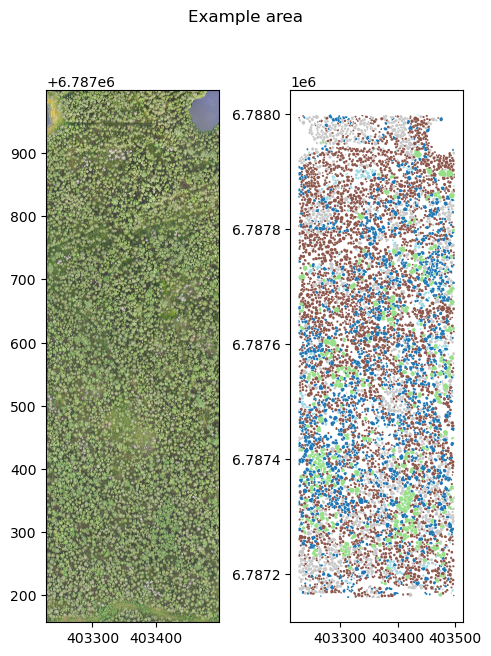

In [ ]:
uav_data = path_to_data/'example_area.tif'
canopy_data = path_to_data/'canopies.geojson'

fig, axs = plt.subplots(1,2, dpi=100, figsize=(5,7))
with rio.open(uav_data) as src:
    rioplot.show((src, (1,2,3)), adjust=True, ax=axs[0])
train_gdf = gpd.read_file(canopy_data)
train_gdf.plot(column='label', ax=axs[1], cmap='tab20')
plt.suptitle('Example area')
plt.tight_layout()
plt.show()

### CLI

```bash
geo2ml_sample_polygons \
example_data/workflow_examples/canopies.geojson \
example_data/workflow_examples/example_area.tif \
label \
example_data/workflow_examples/polygons/ \
--out_prefix example \
--min --max --mean --std --median
```

#### Python

In [ ]:
from geo2ml.scripts.data import sample_polygons

In [ ]:
outpath = path_to_data/'polygons'

sample_polygons(canopy_data, uav_data, 'label', outpath, out_prefix='example',
                min=True, max=True, mean=True, std=True, median=True,
                count=False, sum=False, categorical=False)

/home/mayrajeo/miniconda3/envs/point-eo-dev/lib/python3.11/site-packages/rasterstats/io.py:328: NodataWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn(


### Dataset structure

### Train model

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
df = pd.read_csv(outpath/'example__example_area__canopies__label.csv')

le = LabelEncoder()
y = le.fit_transform(df['label'])
X = df.drop(columns='label')

X_train, X_test, y_train, y_test = train_test_split(X, y)

rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

In [ ]:
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred, zero_division=0, target_names=le.classes_))

                   precision    recall  f1-score   support

            Birch       0.67      0.59      0.63       326
   European aspen       0.85      0.50      0.63       102
    Norway spruce       0.83      0.93      0.87       777
       Scots pine       0.84      0.78      0.81       273
Standing deadwood       0.96      0.96      0.96        74

         accuracy                           0.81      1552
        macro avg       0.83      0.75      0.78      1552
     weighted avg       0.80      0.81      0.80      1552



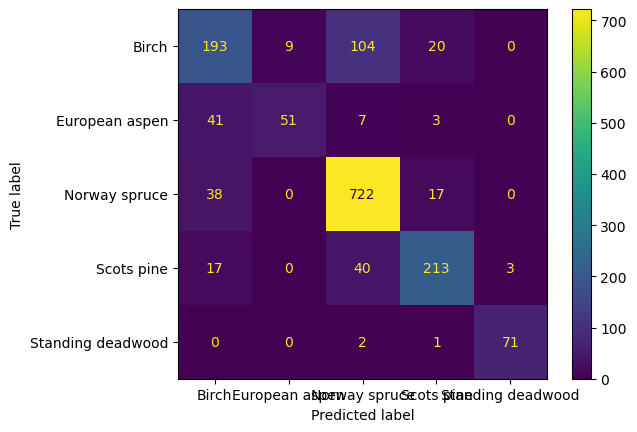

In [ ]:
cm = confusion_matrix(y_test, y_pred, labels=rf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot()
plt.show()